In [10]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = 999
import numpy as np
from scipy.stats import ttest_ind
import scipy.stats as stats
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [2]:
# import os
# os.getcwd()

In true data:<br>
0 = agrees<br>
1 = neutral<br>
2 = disagree<br>

We convert to 1,0,-1 for ease of analysis.

In [2]:
def to_int(x):
    if x == 0:
        return 1
    elif x == 1:
        return 0
    else:
        return -1

In [8]:
#PRED_DIR = 'BERT/bert_preds/'
BERT_PRED_DIR = './BERT/vanilla/uncased/'
PRED_FNAME = 'vanilla_dev_preds.tsv'
DATA_DIR = './data_creation/scripts/save/vanilla/'

# Error analysis scripts

In [98]:
def ttest_accuracy_len(preds_):
    right,wrong = [],[]
    correct_preds_by_len = defaultdict(int)
    total_no_by_len = defaultdict(int)
    for ix,row in preds_.iterrows():
        true = row['true']
        pred = row['predicted']
        text = row['sentence']
        len_ = len(text.split())
        total_no_by_len[len_] += 1
        if true==pred:
            right.append(len_)
            correct_preds_by_len[len_] += 1
        else:
            wrong.append(len_)
    
    return ttest_ind(right,wrong),stats.spearmanr([l for l in correct_preds_by_len],
                                                  [correct_preds_by_len[l]/total_no_by_len[l] 
                                                   for l in correct_preds_by_len])

In [4]:
int(0==0)

1

# BERT+classifier predictions

In [103]:
BERT_PRED_DIR = './BERT/trained_models/'
DATA_DIR = './data_creation/scripts/save/'

In [110]:
def do_error_analysis(pred_filename,true_filename):
    # Load and pre-process
    preds = pd.read_csv(pred_filename,sep='\t',header=0,index_col=False)
    true = pd.read_csv(true_filename,sep='\t',header=None,index_col=False)
    assert len(preds) == len(true)
    preds['true'] = preds['true'].apply(to_int)
    preds['predicted'] = preds['predicted'].apply(to_int)
    true[1] = true[1].apply(to_int)
    #print(true.head(10))
    assert np.sum([(true[1] == preds['true'])]) == len(preds)
    preds['sentence'] = true[0]
    
    bad_preds = preds[preds.true != preds.predicted]
    good_preds = preds[preds.true == preds.predicted]
    opp_preds = bad_preds[bad_preds.true == bad_preds.predicted*-1]
    N_correct = len(good_preds)
    N_wrong = len(bad_preds)
    N_opp = len(opp_preds)
    total_N = len(preds)
    print('Num correct: {},\tNum wrong: {},\tNum opposite: {}\n'.format(N_correct,
                                                                N_wrong,
                                                                N_opp))
    print('Percent correct: {},\tPercent wrong: {},\tPercent opposite: {}\n'\
          .format(round(N_correct/len(preds),3),
                 round(N_wrong/len(preds),3),
                 round(N_opp/len(preds),3)))
    
    prop_opp_from_agrees = round(len(opp_preds[opp_preds.true == 1])/len(opp_preds)*100,2)
    print('Of the opposite preds, {}% were true agrees and {}% were true disagrees.\n'\
         .format(prop_opp_from_agrees,100-prop_opp_from_agrees))
    
    false_neutrals = bad_preds[bad_preds.predicted == 0]
    false_agrees = bad_preds[bad_preds.predicted == 1]
    false_disagrees = bad_preds[bad_preds.predicted == -1]
    true_neutrals = good_preds[good_preds.predicted == 0]
    true_agrees = good_preds[good_preds.predicted == 1]
    true_disagrees = good_preds[good_preds.predicted == -1]
    
    print('Proportion of false agrees: {} (out of {} true agrees)'.\
          format(round(len(false_agrees)/len(preds),3),
                len(true_agrees)))
    print('Distribution of true values of false agrees:\n', 
          false_agrees.true.value_counts())
    
    print('Proportion of false disagrees: {} (out of {} true disagrees)'.\
          format(round(len(false_disagrees)/len(preds),3),
                len(true_disagrees)))
    print('Distribution of true values of false disagrees:\n', 
          false_disagrees.true.value_counts())
    
    print('Proportion of false neutrals: {} (out of {} true neutrals)'.\
          format(round(len(false_neutrals)/len(preds),3),
                len(true_neutrals)))
    print('Distribution of true values of false neutrals:\n', 
          false_neutrals.true.value_counts())
    
    return preds,opp_preds,bad_preds

## Both LM uncased finetuned, trained on vanilla

In [105]:
all_preds = pd.DataFrame()

In [106]:
for data_name in ['vanilla']:#,'vanilla_downsampled']:
    dev_data_fname = os.path.join(DATA_DIR,data_name,'dev.tsv')
    test_data_fname = os.path.join(DATA_DIR,data_name,'test.tsv')
    for LM in ['uncased_both_LM']:#,'cased_LM']:
        for casing in ['uncased']:#,'cased']:
            
            dev_preds_fname = glob.glob(os.path.join(BERT_PRED_DIR,data_name,LM,casing,'*_dev_preds.tsv'))
            if len(dev_preds_fname) > 0:
                dev_preds_fname=dev_preds_fname[0]
                test_preds_fname = glob.glob(os.path.join(BERT_PRED_DIR,data_name,LM,casing,'*_test_preds.tsv'))[0]
                
                print('-=-=--=-=-=-=-=-=-=-=- Results for {} model trained on {} {} data -=-=--=-=-=-=-=-=-=-=-'.\
                      format(LM,casing,data_name))
                dev_preds,opp_dev_preds,bad_dev_preds = do_error_analysis(dev_preds_fname,dev_data_fname)
                all_preds = all_preds.append(dev_preds)
                print(ttest_accuracy_len(dev_preds))

                test_preds,opp_test_preds,bad_test_preds = do_error_analysis(test_preds_fname,test_data_fname)
                all_preds = all_preds.append(test_preds)
                print(ttest_accuracy_len(test_preds))
            else:
                pass

-=-=--=-=-=-=-=-=-=-=- Results for uncased_both_LM model trained on uncased vanilla data -=-=--=-=-=-=-=-=-=-=-
                                                                                                                                                                                                                                   0  \
0  The fall-off in ice volume is so fast it is going to bring us to zero very quickly.                                                                                                                                                 
1  More warming leads to more fires, which release more carbon, which causes more warming, and so on.                                                                                                                                  
2  Just to drive home to people what that means, it means that in 40 years from now we can’t be driving cars that are fueled with fossil fuels, with oil.                                       

In [107]:
opp_dev_preds

,true,predicted,sentence
5,1,-1,"The beans contains some powerful refutations of a number of other global warming denier talking points, as well as some ingenious sequences that explain the planetary-scale significance of climate change."
19,1,-1,But the optics of the protest are clear: climate alarmists insist that the Earth only has 12 years left.
37,1,-1,There are natural ways to address the modern global warming problem.
137,-1,1,Carbon dioxide emissions provide the environmentally vital services of greening the planet and assuring our food supply.


In [108]:
opp_test_preds

,true,predicted,sentence
12,1,-1,The issue of global warming's the height of arrogance for human beings to think that they can control the weather.
63,1,-1,Global warming is like a world war.
81,1,-1,There’s no question that humans have altered the background atmosphere on a global scale.


## LM finetuned, trained on vanilla and vanilla_downsampled

In [109]:
all_preds = pd.DataFrame()

In [111]:
for data_name in ['vanilla','vanilla_downsampled']:
    dev_data_fname = os.path.join(DATA_DIR,data_name,'dev.tsv')
    test_data_fname = os.path.join(DATA_DIR,data_name,'test.tsv')
    for LM in ['uncased_LM','cased_LM']:
        for casing in ['uncased','cased']:
            
            dev_preds_fname = glob.glob(os.path.join(BERT_PRED_DIR,data_name,LM,casing,'*_dev_preds.tsv'))
            if len(dev_preds_fname) > 0:
                dev_preds_fname=dev_preds_fname[0]
                test_preds_fname = glob.glob(os.path.join(BERT_PRED_DIR,data_name,LM,casing,'*_test_preds.tsv'))[0]
                
                print('-=-=--=-=-=-=-=-=-=-=- Results for {} model trained on {} {} data -=-=--=-=-=-=-=-=-=-=-'.\
                      format(LM,casing,data_name))
                dev_preds,opp_preds,bad_preds = do_error_analysis(dev_preds_fname,dev_data_fname)
                print('Opp preds:\n')
                print(opp_preds)
                all_preds = all_preds.append(dev_preds)
                print(ttest_accuracy_len(dev_preds))

                test_preds,opp_preds,bad_preds = do_error_analysis(test_preds_fname,test_data_fname)
                print('Opp preds:\n')
                print(opp_preds)
                all_preds = all_preds.append(test_preds)
                print(ttest_accuracy_len(test_preds))
            else:
                pass

-=-=--=-=-=-=-=-=-=-=- Results for uncased_LM model trained on uncased vanilla data -=-=--=-=-=-=-=-=-=-=-
Num correct: 125,	Num wrong: 15,	Num opposite: 3

Percent correct: 0.893,	Percent wrong: 0.107,	Percent opposite: 0.021

Of the opposite preds, 66.67% were true agrees and 33.33% were true disagrees.

Proportion of false agrees: 0.064 (out of 42 true agrees)
Distribution of true values of false agrees:
  0    8
-1    1
Name: true, dtype: int64
Proportion of false disagrees: 0.021 (out of 23 true disagrees)
Distribution of true values of false disagrees:
 1    2
0    1
Name: true, dtype: int64
Proportion of false neutrals: 0.021 (out of 60 true neutrals)
Distribution of true values of false neutrals:
 1    3
Name: true, dtype: int64
Opp preds:

     true  predicted  \
5    1    -1           
19   1    -1           
137 -1     1           

                                                                                                                                                

(Ttest_indResult(statistic=1.6755253339480274, pvalue=0.09609559498406094), SpearmanrResult(correlation=0.3530419792067537, pvalue=0.03468320459322165))
Num correct: 236,	Num wrong: 24,	Num opposite: 5

Percent correct: 0.908,	Percent wrong: 0.092,	Percent opposite: 0.019

Of the opposite preds, 60.0% were true agrees and 40.0% were true disagrees.

Proportion of false agrees: 0.027 (out of 94 true agrees)
Distribution of true values of false agrees:
  0    5
-1    2
Name: true, dtype: int64
Proportion of false disagrees: 0.015 (out of 34 true disagrees)
Distribution of true values of false disagrees:
 1    3
0    1
Name: true, dtype: int64
Proportion of false neutrals: 0.05 (out of 108 true neutrals)
Distribution of true values of false neutrals:
  1    8
-1    5
Name: true, dtype: int64
Opp preds:

     true  predicted  \
55   1    -1           
60   1    -1           
81   1    -1           
248 -1     1           
250 -1     1           

                                           

Num correct: 168,	Num wrong: 92,	Num opposite: 26

Percent correct: 0.646,	Percent wrong: 0.354,	Percent opposite: 0.1

Of the opposite preds, 50.0% were true agrees and 50.0% were true disagrees.

Proportion of false agrees: 0.138 (out of 60 true agrees)
Distribution of true values of false agrees:
  0    23
-1    13
Name: true, dtype: int64
Proportion of false disagrees: 0.123 (out of 37 true disagrees)
Distribution of true values of false disagrees:
 0    19
1    13
Name: true, dtype: int64
Proportion of false neutrals: 0.092 (out of 71 true neutrals)
Distribution of true values of false neutrals:
  1    21
-1    3 
Name: true, dtype: int64
Opp preds:

     true  predicted  \
7    1    -1           
10   1    -1           
17   1    -1           
25   1    -1           
40   1    -1           
49   1    -1           
52   1    -1           
61   1    -1           
70   1    -1           
78   1    -1           
84   1    -1           
88   1    -1           
89   1    -1           


(Ttest_indResult(statistic=0.3936438869152863, pvalue=0.694169092999805), SpearmanrResult(correlation=0.14369686206199128, pvalue=0.40309570847796794))


In [19]:
len(all_preds)

2540

In [30]:
dev_data_fname = os.path.join(DATA_DIR,'vanilla','dev.tsv')
test_data_fname = os.path.join(DATA_DIR,'vanilla','test.tsv')
best_dev_preds_fname = dev_preds_fname = glob.glob(os.path.join(BERT_PRED_DIR,
                                                                'vanilla','uncased_LM','cased','*_dev_preds.tsv'))[0]
best_test_preds_fname = glob.glob(os.path.join(BERT_PRED_DIR,'vanilla','uncased_LM','cased','*_test_preds.tsv'))[0]
                
print('-=-=--=-=-=-=-=-=-=-=- Results for {} model trained on {} {} data -=-=--=-=-=-=-=-=-=-=-'.\
                      format(LM,casing,data_name))
dev_preds,opp_dev_preds,bad_dev_preds = do_error_analysis(best_dev_preds_fname,dev_data_fname)
test_preds,opp_test_preds,bad_test_preds = do_error_analysis(best_test_preds_fname,test_data_fname)

-=-=--=-=-=-=-=-=-=-=- Results for cased_LM model trained on cased vanilla_downsampled data -=-=--=-=-=-=-=-=-=-=-
                                                                                                                                                                                                                                   0  \
0  The fall-off in ice volume is so fast it is going to bring us to zero very quickly.                                                                                                                                                 
1  More warming leads to more fires, which release more carbon, which causes more warming, and so on.                                                                                                                                  
2  Just to drive home to people what that means, it means that in 40 years from now we can’t be driving cars that are fueled with fossil fuels, with oil.                                    

In [32]:
dev_preds.shape,test_preds.shape

((140, 3), (260, 3))

In [31]:
bad_dev_preds.shape,bad_test_preds.shape

((15, 3), (25, 3))

In [28]:
bad_preds.drop(5)

,true,predicted,sentence
11,1,0,"As the Antarctic ice sheet continues to melt away, we expect multi-meter sea level rise from Antarctica in the coming centuries."
12,1,0,ExxonMobil for years had understood the climate risks associated with fossil fuels while publicly downplaying the danger.
46,1,0,The U.S. has 10 years left to act on climate change.
51,0,1,Carbon pollution harms human health and is therefore subject to the Clean Air Act.
74,0,1,"Some governments are taking serious action to mitigate global warming, when in reality they have achieved almost nothing."
76,0,-1,Global temperatures had not risen in the past decade.
83,0,1,The real Arctic environmental worries are oil spills and similar disasters.
85,0,1,These are the effects of climate change.
87,0,1,"It is not hypocritical to use fossil fuels in order to try to get ourselves off of fossil fuels, particularly since this is simply unavoidable."
89,0,1,A nuclear war could plunge the world into a deadly ice age.


In [36]:
bad_test_preds.drop([28,239,248,89,234])

,true,predicted,sentence
0,1,0,And that’s not the only way global warming causes psychological problems.
4,1,0,"We are committed to tackling climate change without a carbon tax or an emissions-trading scheme that will hike up power bills for families, pensioners and businesses."
6,1,0,"Levels of carbon dioxide and methane, the two most influential of greenhouse gases, reached record highs in 2011."
24,1,-1,The leader of a company that disputes a threat from global warming has no place at an institution where scientists have underscored the seriousness of the problem and administrators.
27,1,0,Now we feel like the E.P.A. is being run by the fossil fuel industry.
32,1,0,A 50-gigaton “ burp ” of methane from thawing Arctic permafrost beneath the East Siberian sea is highly possible at anytime.
69,1,0,You could do everything possible to minimize your own carbon footprint.
72,1,0,"We see warming across the board, and generally the rate of warming is increasing."
76,1,0,"Thatâs a lot of money for Mr. Pruitt to tour the Vatican, pose for photos, and tell his European counterparts that global warming doesnât matter."
127,0,1,A global reduction in HFCs could prevent 0.5 degrees Celsius in warming over the next century.


## Standardized test/dev set vanilla MTurk

In [128]:
BERT_PRED_DIR = './BERT/vanilla/uncased/'
PRED_FNAME = 'vanilla_dev_preds.tsv'
DATA_DIR = './data_creation/scripts/save/vanilla/'

In [136]:
dev_preds,opp_preds,bad_preds = do_error_analysis(PRED_FNAME,'dev.tsv')
#all_preds = all_preds.append(dev_preds)

                                                                                                                                                                                                                                                   0  \
0  Global warming has already caused significant crises in Africa.                                                                                                                                                                                     
1  We canât retreat from the rising sea.                                                                                                                                                                                                             
2  Existing national pledges to restrict greenhouse gas emissions are insufficient to limit warming to 2 degrees Celsius (3.6 Fahrenheit) above pre-industrial times, a U.N. ceiling set in 2010 to limit heatwaves, floods, storms and rising seas.   
3  There

In [146]:
exs_for_slides = [40,51,56,64,112,108,107,116,128,125,127,134,139]
bad_preds.loc[exs_for_slides]

,true,predicted,sentence
40,1,0,"I’m from a coal state, so I believe that if there’s going to be a future for coal it has to be one that deals with carbon pollution, with climate change."
51,1,0,"63% of all human-generated carbon emissions have been produced in the past 25 years; that is, nearly two-thirds have been emitted since the first warnings were sounded about what was then called “ global warming ”."
56,0,1,These are the effects of climate change.
64,0,1,"If carbon dioxide emissions continue to rise beyond 2020, or even remain level, the temperature goals set in Paris become almost unattainable."
112,0,-1,The proposed carbon tax on beef has no chance of becoming reality.
108,0,1,"Dealing with global warming has become normal, and that’s a good thing."
107,0,1,"Science tells us that on our current path, we face at least 3-degrees Celsius of global heating by the end of the century."
116,-1,0,"With respect to climate change, it has yet to be determined precisely what the role of human activity is, and in particular, how sensitive the climate is to increased atmospheric carbon dioxide."
128,-1,0,There are fewer climate problems elsewhere.
125,-1,1,No single storm can be laid at the foot of global warming.


In [142]:
bad_preds

,true,predicted,sentence
1,1,0,We canât retreat from the rising sea.
2,1,0,"Existing national pledges to restrict greenhouse gas emissions are insufficient to limit warming to 2 degrees Celsius (3.6 Fahrenheit) above pre-industrial times, a U.N. ceiling set in 2010 to limit heatwaves, floods, storms and rising seas."
5,1,0,No one can say they are happy about climate change.
12,1,0,"Saving a tropical forest of, say, a million acres would prevent roughly 367 million tons of carbon dioxide from escaping into the atmosphere, where some of it would remain for thousands of years."
17,1,0,Co2 is responsible for the apparent global temperature increase.
19,1,-1,"Far from staying flat since 1998, global temperatures have carried on rising."
22,1,0,These solutions may not help with global warming's long-term effects.
28,1,-1,"The word climate change, to the best of my knowledge, is not discussed in this new NAFTA agreement at all, which is an outrage."
29,1,0,"Levels of carbon dioxide and methane, the two most influential of greenhouse gases, reached record highs in 2011."
31,1,0,"Global warning, and not El Niño, has caused the record highs."


In [97]:
ttest_accuracy_len(dev_preds)

(Ttest_indResult(statistic=0.5521803988170595, pvalue=0.5817179379267896),
 SpearmanrResult(correlation=-0.46910283914967144, pvalue=0.0039008083058702683))

In [98]:
BERT_PRED_DIR = './BERT/vanilla/uncased/'
PRED_FNAME = 'vanilla_test_preds.tsv'
DATA_DIR = './data_creation/scripts/save/vanilla/'

In [99]:
test_preds,opp_preds,bad_preds = do_error_analysis(PRED_FNAME,'test.tsv')
all_preds = all_preds.append(test_preds)

                                                                                                                                                                                0  \
0  Such problems will be vastly worse if global temperatures continue to rise.                                                                                                      
1  The steady retreat of sea ice sea ice may have a residual effect on all sorts of other things, like the ice covering Greenland or storms in New England.                         
2  One round-trip flight from New York to Europe or to San Francisco creates a warming effect equivalent to 2 or 3 tons of carbon dioxide per person.                               
3  Climate change is a global catastrophe that’s unfolding before our very eyes in slow motion.                                                                                     
4  Global warming is real.                                                                     

In [100]:
ttest_accuracy_len(test_preds)

(Ttest_indResult(statistic=-0.8619316669012971, pvalue=0.3895255291303297),
 SpearmanrResult(correlation=-0.5726837408920789, pvalue=0.00021218977489691714))

In [101]:
ttest_accuracy_len(all_preds)

(Ttest_indResult(statistic=-0.3975812452633035, pvalue=0.6911520336958671),
 SpearmanrResult(correlation=-0.6501585091936807, pvalue=5.609570844893678e-06))

## Standardized test/dev set downsampled vanilla MTurk

In [102]:
BERT_PRED_DIR = './BERT/vanilla_downsampled/uncased/'
PRED_FNAME = 'vanilla_downsampled_dev_preds.tsv'
DATA_DIR = './data_creation/scripts/save/vanilla_downsampled/'

In [103]:
dev_preds,opp_preds,bad_preds = do_error_analysis(PRED_FNAME,'dev.tsv')
all_preds = all_preds.append(dev_preds)

                                                                                                                                                                                                                                                   0  \
0  Global warming has already caused significant crises in Africa.                                                                                                                                                                                     
1  We canât retreat from the rising sea.                                                                                                                                                                                                             
2  Existing national pledges to restrict greenhouse gas emissions are insufficient to limit warming to 2 degrees Celsius (3.6 Fahrenheit) above pre-industrial times, a U.N. ceiling set in 2010 to limit heatwaves, floods, storms and rising seas.   
3  There

In [104]:
ttest_accuracy_len(dev_preds)

(Ttest_indResult(statistic=-1.7687851188364176, pvalue=0.07913899151316878),
 SpearmanrResult(correlation=-0.46910283914967144, pvalue=0.0039008083058702683))

In [105]:
BERT_PRED_DIR = './BERT/vanilla_downsampled/uncased/'
PRED_FNAME = 'vanilla_downsampled_test_preds.tsv'
DATA_DIR = './data_creation/scripts/save/vanilla_downsampled/'

In [106]:
test_preds,opp_preds,bad_preds = do_error_analysis(PRED_FNAME,'test.tsv')
all_preds = all_preds.append(test_preds)

                                                                                                                                                                                0  \
0  Such problems will be vastly worse if global temperatures continue to rise.                                                                                                      
1  The steady retreat of sea ice sea ice may have a residual effect on all sorts of other things, like the ice covering Greenland or storms in New England.                         
2  One round-trip flight from New York to Europe or to San Francisco creates a warming effect equivalent to 2 or 3 tons of carbon dioxide per person.                               
3  Climate change is a global catastrophe that’s unfolding before our very eyes in slow motion.                                                                                     
4  Global warming is real.                                                                     

In [107]:
ttest_accuracy_len(test_preds)

(Ttest_indResult(statistic=-1.340300558966157, pvalue=0.18132673917574907),
 SpearmanrResult(correlation=-0.5726837408920789, pvalue=0.00021218977489691714))

In [108]:
ttest_accuracy_len(all_preds)

(Ttest_indResult(statistic=-1.8787105599861054, pvalue=0.060648342028071074),
 SpearmanrResult(correlation=-0.6501585091936807, pvalue=5.609570844893678e-06))

## Standardized test/dev set backtrans. augmented MTurk (fr + zh)

In [109]:
BERT_PRED_DIR = './BERT/with_backtrans/uncased/'
PRED_FNAME = 'backtrans_dev_preds.tsv'
DATA_DIR = './data_creation/scripts/save/with_backtrans/'

In [110]:
dev_preds,opp_preds,bad_preds = do_error_analysis(PRED_FNAME,'dev.tsv')
all_preds = all_preds.append(dev_preds)

                                                                                                                                                                                                                                                   0  \
0  Global warming has already caused significant crises in Africa.                                                                                                                                                                                     
1  We canât retreat from the rising sea.                                                                                                                                                                                                             
2  Existing national pledges to restrict greenhouse gas emissions are insufficient to limit warming to 2 degrees Celsius (3.6 Fahrenheit) above pre-industrial times, a U.N. ceiling set in 2010 to limit heatwaves, floods, storms and rising seas.   
3  There

In [111]:
ttest_accuracy_len(dev_preds)

(Ttest_indResult(statistic=0.4922749534379426, pvalue=0.6233072209241515),
 SpearmanrResult(correlation=-0.46910283914967144, pvalue=0.0039008083058702683))

In [112]:
BERT_PRED_DIR = './BERT/with_backtrans/uncased/'
PRED_FNAME = 'backtrans_test_preds.tsv'
DATA_DIR = './data_creation/scripts/save/with_backtrans/'

In [113]:
test_preds,opp_preds,bad_preds = do_error_analysis(PRED_FNAME,'test.tsv')
all_preds = all_preds.append(test_preds)

                                                                                                                                                                                0  \
0  Such problems will be vastly worse if global temperatures continue to rise.                                                                                                      
1  The steady retreat of sea ice sea ice may have a residual effect on all sorts of other things, like the ice covering Greenland or storms in New England.                         
2  One round-trip flight from New York to Europe or to San Francisco creates a warming effect equivalent to 2 or 3 tons of carbon dioxide per person.                               
3  Climate change is a global catastrophe that’s unfolding before our very eyes in slow motion.                                                                                     
4  Global warming is real.                                                                     

In [114]:
ttest_accuracy_len(test_preds)

(Ttest_indResult(statistic=-1.4410393499510705, pvalue=0.15078611143689669),
 SpearmanrResult(correlation=-0.5726837408920789, pvalue=0.00021218977489691714))

In [115]:
ttest_accuracy_len(all_preds)

(Ttest_indResult(statistic=-2.0275658217912333, pvalue=0.04282558664609475),
 SpearmanrResult(correlation=-0.6501585091936807, pvalue=5.609570844893678e-06))

(array([153., 291., 258., 228., 162.,  48.,  45.,   3.,   6.,   6.]),
 array([ 4. ,  9.3, 14.6, 19.9, 25.2, 30.5, 35.8, 41.1, 46.4, 51.7, 57. ]),
 <a list of 10 Patch objects>)

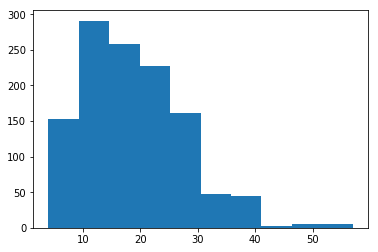

In [126]:
plt.hist([len(s.split()) for s in all_preds.sentence.values])

(array([101., 186., 203., 142., 102.,  34.,  18.,   3.,   5.,   3.]),
 array([ 4. ,  9.3, 14.6, 19.9, 25.2, 30.5, 35.8, 41.1, 46.4, 51.7, 57. ]),
 <a list of 10 Patch objects>)

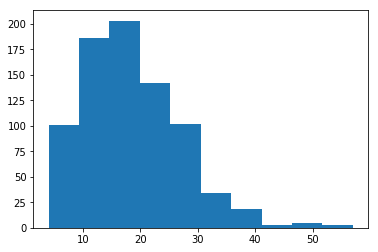

In [121]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist([len(s.split()) for s in all_preds[all_preds.true==all_preds.predicted].sentence.values])

(array([71., 97., 58., 72., 60., 20., 21.,  0.,  1.,  3.]),
 array([ 5. , 10.2, 15.4, 20.6, 25.8, 31. , 36.2, 41.4, 46.6, 51.8, 57. ]),
 <a list of 10 Patch objects>)

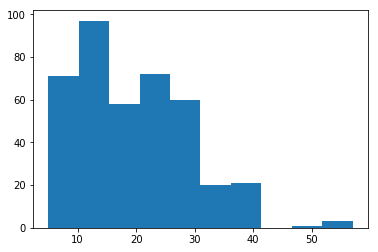

In [122]:
plt.hist([len(s.split()) for s in all_preds[all_preds.true!=all_preds.predicted].sentence.values])

(array([ 28.,  77., 132.,  69.,  38.,  58.,  19.,  14.,   0.,   2.]),
 array([ 5. ,  9.4, 13.8, 18.2, 22.6, 27. , 31.4, 35.8, 40.2, 44.6, 49. ]),
 <a list of 10 Patch objects>)

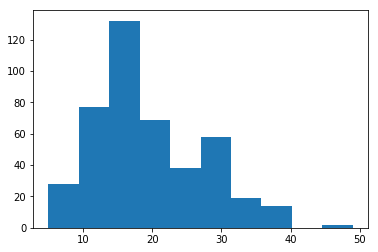

In [125]:
plt.hist([len(s.split()) for s in all_preds[all_preds.true==-1*all_preds.predicted].sentence.values])

## Windowed training data (MTurk), window size = 1

In [23]:
window_1_preds_dev,window_1_opp_preds_dev,window_1_bad_preds_dev = do_error_analysis('windowed_mturk_1_dev_preds.tsv',
                 'mturk_windowed_1/dev.tsv')

                                                                                                                                                                                                      0  \
0  If carbon dioxide emissions continue to rise beyond 2020, or even remain level, the temperature goals set in Paris become almost unattainable.                                                         
1  45 % of the general public view perceived global warming as caused by humans.                                                                                                                          
2  Carbon dioxide will hit another record high in 201.                                                                                                                                                    
3  Four in ten Americans (40%) have personally experienced the effects of global warming.                                                                                                   

In [24]:
window_1_preds_test,window_1_opp_preds_test,window_1_bad_preds_test = do_error_analysis('windowed_mturk_1_test_preds.tsv',
                 'mturk_windowed_1/test.tsv')

                                                                                                                                                                            0  \
0  Warmer-than-normal sea surface temperatures are a key player in the development of hurricanes such as Katrina and superstorm Sandy, which hit the U.S. east coast in 2011.   
1  We will continue to rely in part on fossil fuels while we transition to a low-carbon economy .                                                                               
2  Some parts of the world the world, such as the coast of California, saw sea levels fall.                                                                                     
3  Tackling climate change will be the greatest global health opportunity of the 21st century .                                                                                 
4  The West Antarctic ice sheet could disappear in as little as 1,000 years.                                       

In [26]:
window_1_opp_preds_test

,true,predicted,sentence
9,1,-1,They are too pessimistic about the chances of limiting global warming.
10,-1,1,"Global warming may be occurring more slowly than earlier thought, and that previous climate models may have been on the hot side."
20,1,-1,Co2 is a demon molecule that causes global warming.
26,-1,1,Global warming is overestimated by 100 % over 20 years.
27,-1,1,Global warming global warming is natural.
29,-1,1,The global warming of the 1900s is caused by a rise in solar output.
41,-1,1,From 1860-1880 as well as from 1910-1940 the rate of global warming is the same as from 1980-200.
44,-1,1,Human activities are not a major cause of global warming.
53,1,-1,This is evidence of man-made global warming.
58,-1,1,Global cooling is coming.


In [25]:
window_1_opp_preds_test['sentence'].values

array(['They are too pessimistic about the chances of limiting global warming.',
       'Global warming may be occurring more slowly than earlier thought, and that previous climate models may have been on the hot side.',
       'Co2 is a demon molecule that causes global warming.',
       'Global warming is overestimated by 100 % over 20 years.',
       'Global warming global warming is natural.',
       'The global warming of the 1900s is caused by a rise in solar output.',
       'From 1860-1880 as well as from 1910-1940 the rate of global warming is the same as from 1980-200.',
       'Human activities are not a major cause of global warming.',
       'This is evidence of man-made global warming.',
       'Global cooling is coming.',
       'The fifteen-year long “ global warming ” campaign all along meant “ climate change ” and that this in turn means that places supposed to get hotter get hotter and that places that are supposed to get colder — under global warming, er, climate ch

In [129]:
window_1_preds_downsampled_mturk_test,\
window_1_opp_preds_downsampled_mturk_test,\
window_1_bad_preds_downsampled_mturk_test = do_error_analysis('windowed_1_mturk_model_eval_on\
_downsampled_test_preds.tsv',
                 'downsampled_mturk/test.tsv')

                                                                                                                                                                                                                                                                                                                               0  \
0  The ridiculously warm temperatures in the Arctic during October and November this year this year are off the charts over our 68 years of measurements.                                                                                                                                                                          
1  No one can say they are happy about climate change.                                                                                                                                                                                                                                                                             
2  Earlier this year painted

In [146]:
window_1_preds_downsampled_mturk_dev,\
window_1_opp_preds_downsampled_mturk_dev,\
window_1_bad_preds_downsampled_mturk_dev = do_error_analysis('windowed_1_mturk_model_eval_on\
_downsampled_dev_preds.tsv',
                 'downsampled_mturk/dev.tsv')

                                                                                                                                                                                                                                                 0  \
0  The effects of decisions like these will be felt for generations as global warming leads to more powerful storms and higher risk of damage to property.                                                                                           
1  Hawaii is committed to environmental stewardship, and we look forward to working with other states to fight global climate change.                                                                                                                
2  The global south in particular is both more vulnerable to the effects of climate change and less equipped to deal with those effects.                                                                                                             
3  They would lo

## Windowed training data (MTurk), window size = 2

In [41]:
window_2_preds_dev,window_2_opp_preds_dev,window_2_bad_preds_dev = do_error_analysis('windowed_mturk_dev_preds.tsv',
                 'mturk_windowed_2/dev.tsv')

                                                                                                                                                                                                      0  \
0  If carbon dioxide emissions continue to rise beyond 2020, or even remain level, the temperature goals set in Paris become almost unattainable.                                                         
1  45 % of the general public view perceived global warming as caused by humans.                                                                                                                          
2  Carbon dioxide will hit another record high in 201.                                                                                                                                                    
3  Four in ten Americans (40%) have personally experienced the effects of global warming.                                                                                                   

In [30]:
window_2_opp_preds_dev

,true,predicted,sentence
6,-1,1,By now there should have been global warming equivalent to 2.8 degrees / century.
16,1,-1,Global warming is what is causing the climate to change .
20,1,-1,The United States government has violated their constitutional rights by allowing fossil fuel production to continue — despite knowing its effects on the planet.
23,1,-1,The basics are clear long ago and the response to global warming is more about ethics and economics than data.
38,1,-1,Global warming global warming global warming global warming turns out to be as real and present and dangerous as ever it is.
45,-1,1,The water level is affected by things other than global warming.
48,-1,1,Global warming causes increased human lifespans.
60,-1,1,Flat hurricanes have not become more numerous and stronger due to carbon pollution.
61,1,-1,"The beans contains some powerful refutations of a number of other global warming denier talking points, as well as some ingenious sequences that explain the planetary-scale significance of climate change."
71,1,-1,— Climate change is causing significant social unrest — is one that is being repeated with greater frequency by leading proponents of the theory humans are primarily responsible for causing global warming.


In [40]:
window_2_preds_test,window_2_opp_preds_test,window_2_bad_preds_test = do_error_analysis('windowed_mturk_test_preds.tsv',
                 'mturk_windowed_2/test.tsv')

                                                                                                                                                                            0  \
0  Warmer-than-normal sea surface temperatures are a key player in the development of hurricanes such as Katrina and superstorm Sandy, which hit the U.S. east coast in 2011.   
1  We will continue to rely in part on fossil fuels while we transition to a low-carbon economy .                                                                               
2  Some parts of the world the world, such as the coast of California, saw sea levels fall.                                                                                     
3  Tackling climate change will be the greatest global health opportunity of the 21st century .                                                                                 
4  The West Antarctic ice sheet could disappear in as little as 1,000 years.                                       

In [32]:
window_2_opp_preds_test

,true,predicted,sentence
9,1,-1,They are too pessimistic about the chances of limiting global warming.
19,1,-1,"Anyone objectively looking at the data, even at the graph produced above, can see that climate models are much, much, much better at predicting global warming over the past decade."
20,1,-1,Co2 is a demon molecule that causes global warming.
26,-1,1,Global warming is overestimated by 100 % over 20 years.
41,-1,1,From 1860-1880 as well as from 1910-1940 the rate of global warming is the same as from 1980-200.
...,...,...,...
428,1,-1,Climate change is an absolute first-order issue.
434,-1,1,The climate is always changing in accordance with natural causes and recent changes.
441,1,-1,What will you tell your children is the reason to fail and leave them facing a climate chaos that you knowingly brought upon them.
447,-1,1,"Young people like Thunberg are simply being used as ""human shields"" for adult climate activists who recognize that the climate scare will soon lose credibility."


## Flattened training data (MTurk)

In [39]:
flattened_preds_dev,flattened_opp_preds_dev,flattened_bad_preds_dev = do_error_analysis('flattened_mturk_dev_preds.tsv',
                 'mturk_flat/dev.tsv')

                                                                                                                                                                                                0  \
0  Global warming is mainly caused by human activity.                                                                                                                                               
1  Humans are causing global warming.                                                                                                                                                               
2  Since 1978, the winter Arctic ice cap has shrunk by 12 percent per decade.                                                                                                                       
3  The paper in no way diminishes the extensive body of observations that global warming is happening and that it is largely due to human activity.                                                 
4  One round-tr

In [6]:
opp_preds_dev

,true,predicted,sentence
3,1,-1,The paper in no way diminishes the extensive body of observations that global warming is happening and that it is largely due to human activity.
46,1,-1,The powerful of the world ignore the immense devastation wrought by pollution in favor of an ideologically driven crusade against global warming.
53,1,-1,"Global warming causes more prostitution, barroom brawls, airline turbulence."
73,1,-1,"Hurricanes are among the extreme weather events that have been exacerbated by manâs selfishness, greed, and refusal to amend his carbon-guzzling lifestyle."
88,1,-1,You have failed in humanity's task of protecting the climate.
208,-1,1,Global warming global warming is natural.
211,-1,1,Global warming is a relatively distant threat.
217,-1,1,"While the world is in turmoil and falling apart in so many different ways especially with ISIS, our President is worried about global warming–what a ridiculous situation."
228,-1,1,The hurricane isnât âentirely a product of climate changeâ and severe weather has existed for eons before fossil fuels were used.
229,-1,1,The findings will infuriate environmental campaigners who argue by 2030 we could be facing increased sea levels and flooding due to glacial melt at the poles.


In [38]:
flattened_preds_test,flattened_opp_preds_test,flattened_bad_preds_test = do_error_analysis('flattened_mturk_test_preds.tsv',
                 'mturk_flat/test.tsv')

                                                                                                                                                                                                                                        0  \
0  The level of carbon dioxide in the atmosphere has never been higher.                                                                                                                                                                     
1  Human emissions of greenhouse gases are causing global warming.                                                                                                                                                                          
2  Global warming will harm Americans.                                                                                                                                                                                                      
3  Progress in avoiding environmental regrets can co

In [9]:
opp_preds_test

,true,predicted,sentence
4,1,-1,And that’s not the only way global warming causes psychological problems.
25,1,-1,"Global warming, unsurprisingly, is bad news for snowpack."
54,1,-1,Global warming is to blame.
58,1,-1,The issue of global warming's the height of arrogance for human beings to think that they can control the weather.
84,1,-1,"Ice at both ends of the Earth is melting far faster, and oceans are warming far faster, than previously thought, suggesting that scientific estimates of a warming planet have been too conservative."
117,1,-1,Beating climate change won't require a miracle.
315,-1,1,"It gives us a dangerous climate that we make safe, above all, by using energy from fossil fuels."
318,-1,1,Global warming has been at a plateau since 1990.
329,-1,1,"All that our world leaders need is a little more common sense, in order to avoid the nonsense of seeking a globally-binding treaty to reduce CO2 emissions."
330,-1,1,The world will avoid global warming of more than 2C above pre-industrial levels.


## Downsampled vanilla MTurk training

In [37]:
downsampled_preds_dev,downsampled_opp_preds_dev,downsampled_bad_preds_dev = do_error_analysis('downsampled_mturk_dev_preds.tsv',
                 'downsampled_mturk/dev.tsv')

                                                                                                                                                                                                                                                 0  \
0  The effects of decisions like these will be felt for generations as global warming leads to more powerful storms and higher risk of damage to property.                                                                                           
1  Hawaii is committed to environmental stewardship, and we look forward to working with other states to fight global climate change.                                                                                                                
2  The global south in particular is both more vulnerable to the effects of climate change and less equipped to deal with those effects.                                                                                                             
3  They would lo

In [79]:
# Train on downsampled MTurk; evaluate on dev MTurk
opp_preds

,true,predicted,sentence
31,1,-1,They are too pessimistic about the chances of limiting global warming.
45,1,-1,Its appropriate to call such storms global warming type events.
167,-1,1,The magnitude of the dryness is well beyond what global warming would be able to do so far.
171,-1,1,Global warming is occurring more slowly than computer models forecast a decade ago.
185,-1,1,Global warming can be tackled without changing entrenched patterns of production and consumption in industrialized societies.
188,-1,1,"Ultimately, global warming has become the sole focus of so much environmental discussion that it risks eclipsing much more pressing and demonstrable environmental problems."
189,-1,1,Mitch McConnell and the Republican Party are going to boldly confront climate change and create millions of jobs in the process.
207,-1,1,By now there should have been global warming equivalent to 2.8 degrees / century.
210,-1,1,Policies designed to curb global warming would hurt the economy.
225,-1,1,"All that our world leaders need is a little more common sense, in order to avoid the nonsense of seeking a globally-binding treaty to reduce CO2 emissions."


In [36]:
downsampled_preds_test,downsampled_opp_preds_test,downsampled_bad_preds_test = do_error_analysis('downsampled_mturk_test_preds.tsv',
                 'downsampled_mturk/test.tsv')

                                                                                                                                                                                                                                                                                                                               0  \
0  The ridiculously warm temperatures in the Arctic during October and November this year this year are off the charts over our 68 years of measurements.                                                                                                                                                                          
1  No one can say they are happy about climate change.                                                                                                                                                                                                                                                                             
2  Earlier this year painted

In [82]:
opp_preds_test

,true,predicted,sentence
0,1,-1,The ridiculously warm temperatures in the Arctic during October and November this year this year are off the charts over our 68 years of measurements.
5,1,-1,Living like climate change is real and that we can do something about it are signals to others.
10,1,-1,The low number is derived from a method that did not take account of the way global warming had sped up since the 1970s.
37,1,-1,"It does not include a discussion on climate change, which is an outrage."
87,1,-1,No use in denying global warming exists.
89,1,-1,"Global warming is the tide coming in, and El Nio is the waves."
102,1,-1,"The beans contains some powerful refutations of a number of other global warming denier talking points, as well as some ingenious sequences that explain the planetary-scale significance of climate change."
115,1,-1,The missed deadline underscores the disdain with which the Trump administration views the worldwide effort to rein in global warming.
116,1,-1,"Today 's [ Green New Deal ] vote is a partisan stunt to side-step needed debate on climate action, and give Republicans cover to put oil lobby checks over our kids."
146,1,-1,"Global warming is real, because the rise of terrorism tracks with their adjusted climate data."


## Vanilla MTurk only trained model

BERT trained on MTurk only, no downsampling:

In [42]:
vanilla_mturk_preds_dev,vanilla_mturk_opp_preds_dev,vanilla_mturk_bad_preds_dev = do_error_analysis('mturk_only_dev_preds.tsv',
                 'mturk_only/dev.tsv')

FileNotFoundError: [Errno 2] File b'./data_creation/scripts/save/mturk_only/dev.tsv' does not exist: b'./data_creation/scripts/save/mturk_only/dev.tsv'

More of the opposite predictions are coming from true "disagrees" than "agrees".

In [43]:
len(opp_preds[opp_preds.true == 1])/len(opp_preds)

0.18181818181818182

In [44]:
len(opp_preds[opp_preds.true == -1])/len(opp_preds)

0.8181818181818182

In [58]:
opp_preds

,true,predicted,sentence
31,1,-1,They are too pessimistic about the chances of limiting global warming.
45,1,-1,Its appropriate to call such storms global warming type events.
167,-1,1,The magnitude of the dryness is well beyond what global warming would be able to do so far.
171,-1,1,Global warming is occurring more slowly than computer models forecast a decade ago.
185,-1,1,Global warming can be tackled without changing entrenched patterns of production and consumption in industrialized societies.
188,-1,1,"Ultimately, global warming has become the sole focus of so much environmental discussion that it risks eclipsing much more pressing and demonstrable environmental problems."
189,-1,1,Mitch McConnell and the Republican Party are going to boldly confront climate change and create millions of jobs in the process.
207,-1,1,By now there should have been global warming equivalent to 2.8 degrees / century.
210,-1,1,Policies designed to curb global warming would hurt the economy.
225,-1,1,"All that our world leaders need is a little more common sense, in order to avoid the nonsense of seeking a globally-binding treaty to reduce CO2 emissions."


In [173]:
false_neutrals = bad_preds[bad_preds.predicted == 0]
false_agrees = bad_preds[bad_preds.predicted == 1]
false_disagrees = bad_preds[bad_preds.predicted == -1]
true_neutrals = good_preds[good_preds.predicted == 0]
true_agrees = good_preds[good_preds.predicted == 1]
true_disagrees = good_preds[good_preds.predicted == -1]

In [175]:
len(false_agrees)/len(mturk_only_preds)

0.15030674846625766

In [176]:
len(true_agrees)

84

In [177]:
false_agrees.true.value_counts()

 0    28
-1    21
Name: true, dtype: int64

In [179]:
len(false_disagrees)/len(mturk_only_preds)

0.08895705521472393

In [180]:
len(true_disagrees)

27

In [181]:
false_disagrees.true.value_counts()

0    15
1    14
Name: true, dtype: int64

In [182]:
len(false_neutrals)/len(mturk_only_preds)

0.13496932515337423

In [183]:
len(true_neutrals)

93

In [184]:
false_neutrals.true.value_counts()

 1    35
-1    9 
Name: true, dtype: int64

## All data trained model, eval on MTurk only

BERT Trained on all data:

In [131]:
len(opp_preds[opp_preds.true == 1])/len(opp_preds)

0.25

In [132]:
len(opp_preds[opp_preds.true == -1])/len(opp_preds)

0.75

In [119]:
opp_preds

,true,predicted,sentence
13,-1,1,This a sneaky way to cover up the reality that global warming is a sham.
17,-1,1,An increase in C02 emissions from fossil fuels will be a great benefit to plant and animal life on Earth.
42,-1,1,Global warming idiots out of danger.
49,-1,1,"The world may have already begun to cool in response to a weakening Sun, a phenomenon far more dangerous than any possible human-induced warming."
50,-1,1,Global warming helps plants — and thus also helps humans and animals .
58,-1,1,There is a rush to judgment that every time something happens it’s because of global warming.
60,-1,1,"For example, stressing the idea that human activity is behind global warming can be counterproductive."
86,-1,1,Global warming is a relatively distant threat.
88,-1,1,Satellite data disputes global warming.
98,-1,1,Even in liberal states doubt global warming is caused mostly by human carbon emissions.


In [120]:
false_neutrals = bad_preds[bad_preds.predicted == 0]
false_agrees = bad_preds[bad_preds.predicted == 1]
false_disagrees = bad_preds[bad_preds.predicted == -1]
true_neutrals = good_preds[good_preds.predicted == 0]
true_agrees = good_preds[good_preds.predicted == 1]
true_disagrees = good_preds[good_preds.predicted == -1]

In [121]:
len(false_agrees)/407.

0.3857493857493858

In [122]:
len(true_agrees)

132

In [123]:
false_agrees.true.value_counts()

 0    127
-1    30 
Name: true, dtype: int64

In [124]:
len(false_disagrees)/407

0.07616707616707617

In [125]:
len(true_disagrees)

30

In [126]:
false_disagrees.true.value_counts()

0    21
1    10
Name: true, dtype: int64

In [127]:
len(false_neutrals)/407

0.04668304668304668

In [129]:
len(true_neutrals)

38

In [128]:
false_neutrals.true.value_counts()

 1    13
-1    6 
Name: true, dtype: int64

# Compare wrong predictions across models

In [67]:
model_list = ['downsampled_mturk','mturk_flat','mturk_windowed_1','mturk_windowed_2']

In [44]:
flattened_opp_preds_dev.shape

(15, 3)

In [70]:
all_train_sets = {m: pd.read_csv(DATA_DIR+'{}/train.tsv'.format(m),sep='\t',header=None) 
               for m in model_list}
all_dev_sets = {m: pd.read_csv(DATA_DIR+'{}/dev.tsv'.format(m),sep='\t',header=None) 
               for m in model_list}
all_test_sets = {m: pd.read_csv(DATA_DIR+'{}/test.tsv'.format(m),sep='\t',header=None) 
               for m in model_list}

In [72]:
for ix_m in range(len(model_list)-1):
    for ix_m_2 in range(ix_m+1,len(model_list)):
        print('Test size of {} model:'.format(model_list[ix_m]),
             len(all_test_sets[model_list[ix_m]]))
        print('Test size of {} model:'.format(model_list[ix_m_2]),
             len(all_test_sets[model_list[ix_m_2]]))
        print('Test intersection b/w {} and {}:'.format(model_list[ix_m],
                                                        model_list[ix_m_2]),
             len([s for s in all_test_sets[model_list[ix_m]][1].values if s in 
                 all_test_sets[model_list[ix_m_2]][1].values]))
        print('\n')

Test size of downsampled_mturk model: 861
Test size of mturk_flat model: 369
Test intersection b/w downsampled_mturk and mturk_flat: 861


Test size of downsampled_mturk model: 861
Test size of mturk_windowed_1 model: 464
Test intersection b/w downsampled_mturk and mturk_windowed_1: 861


Test size of downsampled_mturk model: 861
Test size of mturk_windowed_2 model: 464
Test intersection b/w downsampled_mturk and mturk_windowed_2: 861


Test size of mturk_flat model: 369
Test size of mturk_windowed_1 model: 464
Test intersection b/w mturk_flat and mturk_windowed_1: 369


Test size of mturk_flat model: 369
Test size of mturk_windowed_2 model: 464
Test intersection b/w mturk_flat and mturk_windowed_2: 369


Test size of mturk_windowed_1 model: 464
Test size of mturk_windowed_2 model: 464
Test intersection b/w mturk_windowed_1 and mturk_windowed_2: 464




In [71]:
for ix_m in range(len(model_list)-1):
    for ix_m_2 in range(ix_m+1,len(model_list)):
        print('Dev size of {} model:'.format(model_list[ix_m]),
             len(all_dev_sets[model_list[ix_m]]))
        print('Dev size of {} model:'.format(model_list[ix_m_2]),
             len(all_dev_sets[model_list[ix_m_2]]))
        print('Dev intersection b/w {} and {}:'.format(model_list[ix_m],
                                                        model_list[ix_m_2]),
             len([s for s in all_dev_sets[model_list[ix_m]][1].values if s in 
                 all_dev_sets[model_list[ix_m_2]][1].values]),
             len(set(all_dev_sets[model_list[ix_m][1].values])))
        print('\n')

Dev size of downsampled_mturk model: 237
Dev size of mturk_flat model: 246
Dev intersection b/w downsampled_mturk and mturk_flat: 237


Dev size of downsampled_mturk model: 237
Dev size of mturk_windowed_1 model: 309
Dev intersection b/w downsampled_mturk and mturk_windowed_1: 237


Dev size of downsampled_mturk model: 237
Dev size of mturk_windowed_2 model: 309
Dev intersection b/w downsampled_mturk and mturk_windowed_2: 237


Dev size of mturk_flat model: 246
Dev size of mturk_windowed_1 model: 309
Dev intersection b/w mturk_flat and mturk_windowed_1: 246


Dev size of mturk_flat model: 246
Dev size of mturk_windowed_2 model: 309
Dev intersection b/w mturk_flat and mturk_windowed_2: 246


Dev size of mturk_windowed_1 model: 309
Dev size of mturk_windowed_2 model: 309
Dev intersection b/w mturk_windowed_1 and mturk_windowed_2: 309




In [66]:
for ix_m in range(len(model_list)-1):
    for ix_m_2 in range(ix_m+1,len(model_list)):
        print('Train size of {} model:'.format(model_list[ix_m]),
             len(all_train_sets[model_list[ix_m]]))
        print('Train size of {} model:'.format(model_list[ix_m_2]),
             len(all_train_sets[model_list[ix_m_2]]))
        print('Train intersection b/w {} and {}:'.format(model_list[ix_m],
                                                        model_list[ix_m_2]),
             len([s for s in all_train_sets[model_list[ix_m]][1].values if s in 
                 all_train_sets[model_list[ix_m_2]][1].values]))
        print('\n')
# Everything in downsampled model is in flattened model
# Everything in downsampled model is included in training data for window_1, window_2

# Lots of training data overlap

Train size of downsampled model: 942
Train size of flattened model: 6435
Train intersection b/w downsampled and flattened: 942


Train size of downsampled model: 942
Train size of window_1 model: 1267
Train intersection b/w downsampled and window_1: 942


Train size of downsampled model: 942
Train size of window_2 model: 1267
Train intersection b/w downsampled and window_2: 942


Train size of flattened model: 6435
Train size of window_1 model: 1267
Train intersection b/w flattened and window_1: 6435


Train size of flattened model: 6435
Train size of window_2 model: 1267
Train intersection b/w flattened and window_2: 6435


Train size of window_1 model: 1267
Train size of window_2 model: 1267
Train intersection b/w window_1 and window_2: 1267




In [76]:
def get_both_wrong(m1,m2):
    return [s for s in m1['sentence'].values if s in m2['sentence'].values]

In [101]:
def get_m1_right(m1_preds,m1_bad_preds,m2_bad_preds): 
    return [s for s in m1_preds['sentence'].values if 
            s not in m1_bad_preds['sentence'].values and 
           s in m2_bad_preds['sentence'].values]

### Window 1 vs. Window 2

In [152]:
both_wrong = get_both_wrong(window_1_bad_preds_dev,window_2_bad_preds_dev)

In [102]:
window1_right = get_m1_right(window_1_preds_dev,window_1_bad_preds_dev,
                            window_2_bad_preds_dev)

In [104]:
window2_right = get_m1_right(window_2_preds_dev,window_2_bad_preds_dev,
                            window_1_bad_preds_dev)

In [109]:
print(len(window1_right),len(window2_right),len(both_wrong),len(window_1_preds_dev),
len(window_2_preds_dev))

39 29 109 309 309


In [115]:
pd.DataFrame(window2_right)

,0
0,Obama Obama plans to suspend new permits for offshore drilling in Arctic waters at least through the rest of this year.
1,"Two extremely broad propositions – carbon dioxide is a “greenhouse gas,” and human activity has warmed the planet to some extent – tallied up the papers in their survey sample that agreed with these propositions to even the slightest degree, and manufactured the “97 percent consensus” factoid."
2,You can’t stop using fossil fuels without killing people and destroying our economies.
3,Antarctica glacier could collapse within decades and “ sink cities ” after the discovery of a 300-meter doomsday cavity lurking below the ice block.
4,The Kemper County Energy Facility is possible to go on burning the dirtiest of fossil fuels and still make the cuts in carbon dioxide emissions needed to avoid a climate catastrophe.
5,The West Antarctic Ice Sheet is broken — already destabilized by irrevocable melting that foreshadows a slow-motion collapse.
6,"63% of all human-generated carbon emissions have been produced in the past 25 years; that is, nearly two-thirds have been emitted since the first warnings were sounded about what was then called “ global warming ”."
7,By the end of the century the chance of Sandy-level flooding in Lower Manhattan in any given year increases to 50 percent.
8,It is inherently self-serving for the Intergovernmental Panel on Climate Change to identify human activities as the cause of global warming.
9,"For everyone else, there are many, many more pressing concerns, and increased “ extreme weather events ” caused by man-made global warming are an alarmist myth."


In [114]:
pd.DataFrame(window1_right)

,0
0,"If carbon dioxide emissions continue to rise beyond 2020, or even remain level, the temperature goals set in Paris become almost unattainable."
1,The world is in the midst of only the third global coral bleaching event ever recorded.
2,Arctic plant species are extremely responsive to fairly rapid climate shifts in the past.
3,Global warming is what is causing the climate to change .
4,2018 is the fourth hottest year on record
5,"“Climate change” is not a high priority for voters, and they haven’t paid much attention to the latest climate confab in Paris, which had a carbon footprint bigger than a thousand normal Americans living average lives for an entire year."
6,"As the ice sheets melt due to global warming, not only do the ice sheets raise the sea level directly."
7,A mini ice age could hit UK by 2030.
8,The evidence shows “ a fundamental shift in the Earth’s plants ” and that global plant growth should be a central goal for the human race.
9,They are on the verge of passing climate legislation at home and a global carbon accord at the Copenhagen talks.


In [153]:
pd.DataFrame(both_wrong)

,0
0,45 % of the general public view perceived global warming as caused by humans.
1,Four in ten Americans (40%) have personally experienced the effects of global warming.
2,By now there should have been global warming equivalent to 2.8 degrees / century.
3,The United States government has violated their constitutional rights by allowing fossil fuel production to continue — despite knowing its effects on the planet.
4,The rate of Antarctic melt is already six times faster than it is just a few decades ago.
5,The basics are clear long ago and the response to global warming is more about ethics and economics than data.
6,"To further pound the point home, the article the article is festooned with imaginative graphics of future human fossils."
7,The Arctic ice cap is melting faster than is predicted even five years ago.
8,"Despite the increased human emissions of greenhouse gases, between 2002 and 2014, plants are somehow able to absorb more carbon dioxide out of the atmosphere than in previous decades."
9,"The reason why more scientists do n’t advocate putting more carbon dioxide in the atmosphere is because the driving force behind the global warming debate, I hate to say it, isn’t science."


### Window 1 vs. no-window, downsampled

In [132]:
both_wrong = get_both_wrong(window_1_bad_preds_downsampled_mturk_test,
                            downsampled_bad_preds_test)
window1_right = get_m1_right(window_1_preds_downsampled_mturk_test,
                             window_1_bad_preds_downsampled_mturk_test,
                            downsampled_bad_preds_test)
downsampled_right = get_m1_right(downsampled_preds_test,downsampled_bad_preds_test,
                            window_1_bad_preds_downsampled_mturk_test)

In [134]:
print(len(window1_right),len(downsampled_right),len(both_wrong),
      len(window_1_preds_downsampled_mturk_test),
len(downsampled_preds_test))

66 180 112 861 861


In [137]:
66/861. # 7.6% of test examples, window 1 got right and reg. downsampled got wrong.
180/861. # Reg. downsampled got 21% right that window 1 got wrong.
112/861. # For 13% of test examples, both models were wrong.

0.13008130081300814

In [141]:
pd.DataFrame(downsampled_right)

,0
0,"If we are to fully exploit this new oil source, and continue to burn we conventional oil, gas and coal supplies, concentrations of carbon dioxide in the atmosphere eventually would reach levels higher than in the Pliocene era, more than 2.5 million years ago, when sea level is at least 50 feet higher than it is now."
1,You can save the climate with electric cars.
2,"The moment we put real limits and real charges on carbon dioxide emissions, we will see a surge of innovation that will discover even better ways for reducing those emissions."
3,The global average temperature is on pace to increase by 4 degrees Celsius (7.2 degrees Fahrenheit) by the end of the century without some form of concrete action on climate issues.
4,"As the Antarctic ice sheet continues to melt away, we expect multi-meter sea level rise from Antarctica in the coming centuries."
5,Global warming spells bad news for polar bears and other creatures that depend on Arctic sea ice.
6,There is a strong connection between melting sea ice and polar bears dying off.
7,Co2 is responsible for the apparent global temperature increase.
8,"If you've been hearing that extreme cold spells, like the one we're having in the United States now, disproves global warming, don't believe it."
9,"Burning all the worlds deposits of coal, oil and natural gas would raise the temperature enough to melt the entire ice sheet covering Antarctica, driving the level of the sea up by more than 160 feet."


In [142]:
pd.DataFrame(window1_right)

,0
0,No one can say they are happy about climate change.
1,Climate change can be blunted only by moving to renewable energy and capping any growth of fossil fuels.
2,Living like climate change is real and that we can do something about it are signals to others.
3,Human emissions of greenhouse gasses essentially control the future of surface melting in Antarctica.
4,"I am a firm believer that climate change is real, that it is impacted by human behavior and carbon emissions."
5,World sea levels are rising on average.
6,"Climate change could actually make frigid waves of Arctic air more common, a result of shrinking sea ice."
7,A warning sign that some scientists worry could mean global warming has passed an ominous tipping point.
8,"About half the population of Cambridge, Massachusetts, across the Charles River from Boston and home to Harvard and MIT, could be locked in to a future below sea level by the early 2060s."
9,Precipitation patterns in California will shift with warming.


In [143]:
# Dev data

In [147]:
both_wrong = get_both_wrong(window_1_bad_preds_downsampled_mturk_dev,
                            downsampled_bad_preds_dev)
window1_right = get_m1_right(window_1_preds_downsampled_mturk_dev,
                             window_1_bad_preds_downsampled_mturk_dev,
                            downsampled_bad_preds_dev)
downsampled_right = get_m1_right(downsampled_preds_dev,downsampled_bad_preds_dev,
                            window_1_bad_preds_downsampled_mturk_dev)

In [148]:
print(len(window1_right),len(downsampled_right),len(both_wrong),
      len(window_1_preds_downsampled_mturk_dev),
len(downsampled_preds_dev))

15 47 38 237 237


In [149]:
pd.DataFrame(downsampled_right)

,0
0,"Because climate change perceptions in children seem less susceptible to the influence of worldview or political context, it may be possible for them to inspire adults toward higher levels of climate concern, and in turn, collective action."
1,"The climate benefits of the program -- as well as the health benefits that will come from a reduction in tailpipe pollution, and the jobs and improved infrastructure that fresh investment will bring -- more than outweigh those costs."
2,Progress in avoiding environmental regrets can come through constructive discussion of ways to cut risks and waste and to sustain a long-term energy quest that extends beyond fossil fuels even while they remain abundant and cheap.
3,Cutting down on fossil fuels is a monumental task but doing so ultimately offered economic as well as ecological benefits.
4,Scientists see no end to the way man-made climate change keeps shattering records.
5,Global warming global warming global warming global warming turns out to be as real and present and dangerous as ever it is.
6,A carbon pricing policy is essential if humanity wants to use the resources of creation wisely.
7,The fall-off in ice volume is so fast it is going to bring us to zero very quickly.
8,"While the data are clear, a global political consensus over how to tackle climate change remains elusive."
9,People are linking recent weather phenomena with the concept of global warming.


In [150]:
pd.DataFrame(window1_right)

,0
0,They would look self-serving and out of touch if they tried to deny climate change.
1,"Warmer-than-normal sea surface temperatures are a key player in the development of hurricanes such as Katrina and superstorm Sandy, which hit the U.S. east coast in 2011."
2,Global warming is not expected to end anytime soon.
3,Global warming can increase snowfall by boosting the amount of moisture in the air.
4,Its appropriate to call such storms global warming type events.
5,"The Obama administration new plan to cut carbon pollution from power plants will not just fight climate change, but will also quickly improve public health, preventing up to 100,000 asthma attacks and 2,100 heart attacks in the first year the rules take effect."
6,Well over 90 percent of published climate scientists have concluded that recent global warming is both real and mostly the result of human activity.
7,Climate change significantly increased the amount of rain that flooded Houston.
8,"In the very act of inventing tools to improve the environment, we will come closer to understanding our place on the planet, as well as in a global society of creatures like ourselves."
9,"The behavior of arctic sea ice represents one of the numerous interesting phenomena that the earth presents us with, and for which neither the understanding nor the needed records exist."


In [151]:
pd.DataFrame(both_wrong)

,0
0,A new Ice Age is coming.
1,"It is urgent to move away from fossil fuels and towards renewable energy, including large scale wind and household solar."
2,"The global average sea level rose to a new record high in 2016, and is about 3.25 inches higher than that observed in 1993, when satellite record-keeping for sea level began."
3,"Not acting on climate change is a ""kind of sin,"" as though God had a political program, and that program involved handing power over to Pete Buttigieg."
4,They are too pessimistic about the chances of limiting global warming.
5,The United States government has violated their constitutional rights by allowing fossil fuel production to continue despite knowing its effects on the planet.
6,Its a smoking gun for sea-level rise causing an acceleration of erosion.
7,ExxonMobil for years had understood the climate risks associated with fossil fuels while publicly downplaying the danger.
8,The measure of introducing a carbon tax should be adopted soon.
9,Tweaking a cow's diet to include 2 percent seaweed could reduce its methane emissions by as much as 99 percent.


# Compute model IAA with annotators

In [ ]:
# Need to take entire batch of annotations and use as eval set

In [37]:
def int_label_to_string(r):
    if r == 0:
        return 'agrees'
    elif r == 1:
        return 'neutral'
    else:
        return 'disagrees'
    
def int_transform(r):
    if r == 0:
        return 1
    elif r == 1:
        return 0
    else:
        return -1

In [45]:
labeled_data = pd.read_pickle('./data_creation/data/labeled_data_df.pkl')
print(labeled_data.shape)
mturk_df = labeled_data.loc[labeled_data.type=='mturk']
print(mturk_df.shape)

(682595, 4)
(2050, 4)


In [47]:
label2int = {'agrees':1,'neutral':0,'disagrees':-1}

full_annotator_ratings = pickle.load(open('./MTurk/MTurk_results/full_ratings_per_round.pkl','rb'))
full_annotator_ratings.keys()

dict_keys([1, 2, 3, 4, 5])

In [39]:
def get_annotator_ratings(r,b,sent_id):
    df_ = full_annotator_ratings[int(r)][int(b)]
    good_workers = get_good_workers(r,b)
    ratings = df_.loc[sent_id][['worker_{}'.format(w_id) for w_id in good_workers]].values
    #ratings = df_.loc[sent_id][['worker_{}'.format(w_id) for w_id in range(0,8)]].values
    
    return ratings

def get_good_workers(r,b):
    df_ = full_annotator_ratings[int(r)][int(b)]
    good_workers = [w_id for w_id in range(0,8) if df_.loc['MACE competence']['worker_{}'.format(w_id)] > 0.4]
    
    return good_workers

In [40]:
r_no = 5

In [57]:
IAAs_dict = {'iaa':[],'true':[],'batch':[]}

In [84]:
for b_no in range(9,10):
    print('=-=-=-=-=-=-=-=-=-=-=-BATCH NUMBER {}-=-=-=-=-=-=-=-=-=-=-==-='.format(b_no))
    MODEL_PRED_FNAME = 'LM_finetuned_mturk_round{}_batch{}_dev_preds.tsv'.format(r_no,b_no)
    print(MODEL_PRED_FNAME)
    model_preds = pd.read_csv('./BERT/bert_preds/'+MODEL_PRED_FNAME,sep='\t',header=0)
    print(model_preds.shape)
    
    # Now read in original data text
    DATA_DIR = './data_creation/scripts/save/'
    ORIG_FNAME = 'mturk_round{}_batch{}/dev.tsv'.format(r_no,b_no)
    print(ORIG_FNAME)
    
    orig_dat = pd.read_csv(DATA_DIR+ORIG_FNAME,sep='\t',header=None)
    print(orig_dat.shape)
    orig_dat.columns=['text','label']
    
    # Check that model preds dataframe is indexed to original dev.tsv
    assert sum(orig_dat.label.values == model_preds.true.values) == len(orig_dat)
    
    good_workers = get_good_workers(r_no,b_no)
    
    # Retrieve annotator labels for "dev" set
    model_annotators_dev_df = pd.DataFrame(columns=['round','batch','s_id','model']+['worker_{}'.format(w_id) 
                                                                                 for w_id in good_workers])
    for ix,row in orig_dat.iterrows():
        text = row.text
        #print(text)
        pred = int_transform(model_preds.iloc[ix]['predicted']) # 0 = agrees -> 1, 1 = neutral -> 0, 2 = disagrees -> -1
        #print('model pred:',pred)
        source_row = mturk_df.loc[mturk_df.text == text]
        source = source_row['source'].values[0]
        split = source.split('_')
        #r = split[0][-1]
        #b = split[1][-1]
        s_id = split[-1][6:]
        #print('s_id:',s_id)
        #print('Batch no:',b_no)
        worker_ratings = get_annotator_ratings(r_no,b_no,s_id)
        row = {'round':r_no,'batch':b_no,'s_id':s_id,'model':pred}
        row.update({
            'worker_{}'.format(w_id):label2int[worker_ratings[i]] for i,w_id in enumerate(good_workers)
        })
        row_df = pd.DataFrame(row,index=[ix])
        #print('row:',row_df)
        model_annotators_dev_df = pd.concat([model_annotators_dev_df,row_df],ignore_index=True)
        
    for w_id in good_workers:
        leave_one_out_df = model_annotators_dev_df\
    [['model']+['worker_{}'.format(w_id) for w_id in good_workers]].T.drop('worker_{}'.format(w_id)).to_numpy()
        iaa = krippendorff_alpha(leave_one_out_df)
        print('Model worker IAA (without worker_{}):'.format(w_id),
             iaa)
        IAAs_dict['iaa'].append(iaa)
        IAAs_dict['batch'].append(b_no)
        IAAs_dict['true'].append(False)
        
    true_iaa = krippendorff_alpha(model_annotators_dev_df[['worker_{}'.format(w_id) for w_id in good_workers]]\
    .T.to_numpy())
    IAAs_dict['iaa'].append(true_iaa)
    IAAs_dict['batch'].append(b_no)
    IAAs_dict['true'].append(True)
    print('True worker IAA:',true_iaa)

=-=-=-=-=-=-=-=-=-=-=-BATCH NUMBER 9-=-=-=-=-=-=-=-=-=-=-==-=
LM_finetuned_mturk_round5_batch9_dev_preds.tsv
(50, 2)
mturk_round5_batch9/dev.tsv
(50, 2)
Model worker IAA (without worker_0): 0.6103269251656349
Model worker IAA (without worker_2): 0.5850566420861387
Model worker IAA (without worker_3): 0.6023004469134483
Model worker IAA (without worker_4): 0.585939056887962
Model worker IAA (without worker_5): 0.5867263339070568
Model worker IAA (without worker_6): 0.6088093656592495
Model worker IAA (without worker_7): 0.5967593293077125
True worker IAA: 0.6507028603517925


In [85]:
IAAs_df = pd.DataFrame(IAAs_dict)
IAAs_df

,iaa,true,batch
0,0.519373,False,0
1,0.511586,False,0
2,0.508092,False,0
3,0.619182,False,0
4,0.536205,False,0
5,0.533569,False,0
6,0.519502,False,0
7,0.515255,False,0
8,0.539864,True,0
9,0.591859,False,1


In [86]:
IAAs_df.loc[IAAs_df.true==True]

,iaa,true,batch
8,0.539864,True,0
15,0.571485,True,1
24,0.518678,True,2
32,0.630735,True,3
40,0.570288,True,4
47,0.712813,True,5
52,0.539669,True,6
57,0.653501,True,7
65,0.619764,True,8
73,0.650703,True,9


Text(0, 0.5, 'Krippendorff alpha')

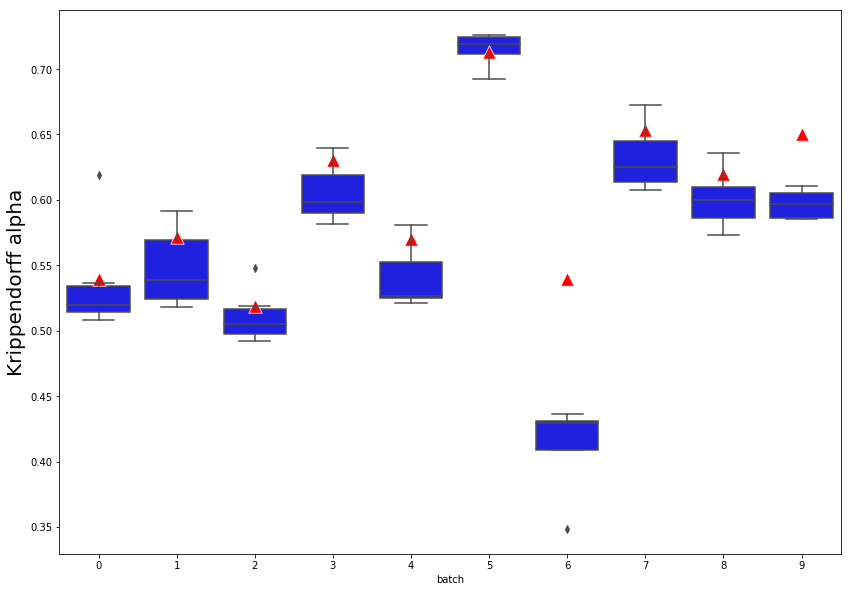

In [87]:
# BERT LM finetuned (uncased) trained on MTurk batches
fig,ax = plt.subplots(figsize=(14,10))
ax = sns.boxplot(data=IAAs_df[IAAs_df.true==False],x='batch',y='iaa',color='b')#,hue='true')
#ax.legend_.remove()
true_df = IAAs_df.loc[IAAs_df.true==True]
ax = sns.scatterplot(data=true_df,x='batch',y='iaa',marker='^',s=180,color='r')
ax.set_ylabel('Krippendorff alpha',fontsize=20)

Text(0, 0.5, 'Krippendorff alpha')

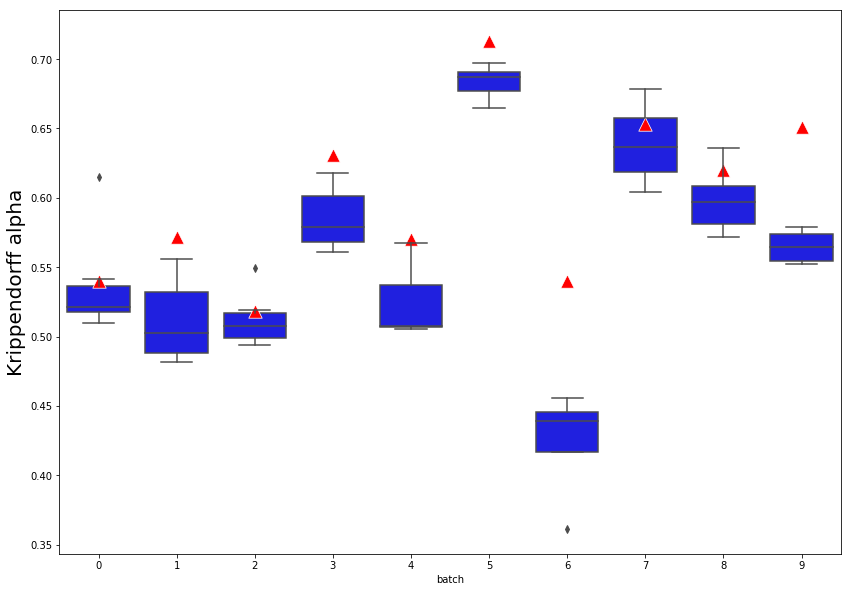

In [440]:
# BERT base trained on MTurk batches
fig,ax = plt.subplots(figsize=(14,10))
ax = sns.boxplot(data=IAAs_df[IAAs_df.true==False],x='batch',y='iaa',color='b')#,hue='true')
#ax.legend_.remove()
true_df = IAAs_df.loc[IAAs_df.true==True]
ax = sns.scatterplot(data=true_df,x='batch',y='iaa',marker='^',s=180,color='r')
ax.set_ylabel('Krippendorff alpha',fontsize=20)

In [49]:
from __future__ import print_function
try:
    import numpy as np
except ImportError:
    np = None
def nominal_metric(a, b):
    return a != b
def interval_metric(a, b):
    return (a-b)**2
def ratio_metric(a, b):
    return ((a-b)/(a+b))**2
def krippendorff_alpha(data, metric=interval_metric, force_vecmath=False, convert_items=float, missing_items=None):
    '''
    Calculate Krippendorff's alpha (inter-rater reliability):
    
    data is in the format
    [
        {unit1:value, unit2:value, ...},  # coder 1
        {unit1:value, unit3:value, ...},   # coder 2
        ...                            # more coders
    ]
    or 
    it is a sequence of (masked) sequences (list, numpy.array, numpy.ma.array, e.g.) with rows corresponding to coders and columns to items
    
    metric: function calculating the pairwise distance
    force_vecmath: force vector math for custom metrics (numpy required)
    convert_items: function for the type conversion of items (default: float)
    missing_items: indicator for missing items (default: None)
    '''
    
    # number of coders
    m = len(data)
    
    # set of constants identifying missing values
    if missing_items is None:
        maskitems = []
    else:
        maskitems = list(missing_items)
    if np is not None:
        maskitems.append(np.ma.masked_singleton)
    
    # convert input data to a dict of items
    units = {}
    for d in data:
        try:
            # try if d behaves as a dict
            diter = d.items()
        except AttributeError:
            # sequence assumed for d
            diter = enumerate(d)
            
        for it, g in diter:
            if g not in maskitems:
                try:
                    its = units[it]
                except KeyError:
                    its = []
                    units[it] = its
                its.append(convert_items(g))


    units = dict((it, d) for it, d in units.items() if len(d) > 1)  # units with pairable values
    n = sum(len(pv) for pv in units.values())  # number of pairable values
    
    if n == 0:
        raise ValueError("No items to compare.")
    
    np_metric = (np is not None) and ((metric in (interval_metric, nominal_metric, ratio_metric)) or force_vecmath)
    
    Do = 0.
    for grades in units.values():
        if np_metric:
            gr = np.asarray(grades)
            Du = sum(np.sum(metric(gr, gri)) for gri in gr)
        else:
            Du = sum(metric(gi, gj) for gi in grades for gj in grades)
        Do += Du/float(len(grades)-1)
    Do /= float(n)

    if Do == 0:
        return 1.

    De = 0.
    for g1 in units.values():
        if np_metric:
            d1 = np.asarray(g1)
            for g2 in units.values():
                De += sum(np.sum(metric(d1, gj)) for gj in g2)
        else:
            for g2 in units.values():
                De += sum(metric(gi, gj) for gi in g1 for gj in g2)
    De /= float(n*(n-1))

    return 1.-Do/De if (Do and De) else 1.

# GPT(?) predictions 

In [51]:
bad_preds['true_stance'] = bad_preds['true_stance'].apply(to_int)
bad_preds['pred_stance'] = bad_preds['pred_stance'].apply(to_int)
good_preds['true_stance'] = good_preds['true_stance'].apply(to_int)
good_preds['pred_stance'] = good_preds['pred_stance'].apply(to_int)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [46]:
bad_preds = preds[preds.true_stance != preds.pred_stance]
good_preds = preds[preds.true_stance == preds.pred_stance]
opp_preds = bad_preds[bad_preds.true_stance == bad_preds.pred_stance*-1]

In [47]:
bad_preds.shape

(111, 4)

In [48]:
good_preds.shape

(53, 4)

In [54]:
opp_preds.shape

(22, 4)

In [55]:
false_neutrals = bad_preds[bad_preds.pred_stance == 0]
false_agrees = bad_preds[bad_preds.pred_stance == 1]
false_disagrees = bad_preds[bad_preds.pred_stance == -1]
true_neutrals = good_preds[good_preds.pred_stance == 0]
true_agrees = good_preds[good_preds.pred_stance == 1]
true_disagrees = good_preds[good_preds.pred_stance == -1]

27% of predictions were false "agrees". More "neutrals" than "disagrees" were falsely predicted.
There were 19 true agrees.

In [31]:
len(false_agrees)/164

0.27439024390243905

In [41]:
len(true_agrees)

19

In [33]:
false_agrees.true_stance.value_counts()

 0    33
-1    12
Name: true_stance, dtype: int64

13% of predictions were false "disagrees". About equal numbers of "agrees" and "neutrals" were falsely predicted. There were 7 true disagrees. 

In [57]:
len(false_disagrees)/164

0.12804878048780488

In [58]:
len(true_disagrees)

7

In [59]:
false_disagrees.true_stance.value_counts()

0    11
1    10
Name: true_stance, dtype: int64

27% of predictions were false neutrals. More "agrees" than "disagrees" were getting predicted to be "neutral".

In [27]:
len(false_neutrals)/164.

0.27439024390243905

In [28]:
false_neutrals.true_stance.value_counts()

 1    29
-1    16
Name: true_stance, dtype: int64

13% of predictions were the opposite of the correct label (e.g., "agree" was predicted "disagree" or vice versa.

In [61]:
len(opp_preds)/164.

0.13414634146341464

Of this 13%, about half are mistaken "agrees" (and the other 55% mistaken "disagrees").

In [24]:
len(opp_preds[opp_preds.true_stance == 1])/len(opp_preds)

0.45454545454545453

In [65]:
opp_preds

,type,sentence,true_stance,pred_stance
4,mturk,Global warming isn't real Leo.,-1,1
6,mturk,"A combination of factors are at work, including a natural El Nino system, man-made global warming and a dash of random weather.",-1,1
17,mturk,The paper in no way diminishes the extensive body of observations that global warming is happening and that it is largely due to human activity.,1,-1
23,mturk,"Carbon dioxide fertilizes plants, and emissions from fossil fuels have already had a hugely beneficial effect on crops, increasing yields by at least 10-15 percent.",-1,1
34,mturk,Global warming is having an impact now.,1,-1
36,mturk,Man-made climate change isn't solely to blame for tropical storms.,-1,1
37,mturk,Fossil fuel investments are pretty good bets regardless of the political climate.,-1,1
58,mturk,The claim made in the 2007 report by the Intergovernmental Panel on Climate Change (IPCC) is unrealistic and the large Himalayan glaciers could not melt in a few decades.,-1,1
59,mturk,Climate change would be used as an excuse to expand `big government' and lead to a loss of personal freedom.,-1,1
61,mturk,Global warming is real.,1,-1


In [63]:
list(opp_preds.sentence)

["Global warming isn't real Leo.",
 'A combination of factors are at work, including a natural El Nino system, man-made global warming and a dash of random weather.',
 'The paper in no way diminishes the extensive body of observations that global warming is happening and that it is largely due to human activity.',
 'Carbon dioxide fertilizes plants, and emissions from fossil fuels have already had a hugely beneficial effect on crops, increasing yields by at least 10-15 percent.',
 'Global warming is having an impact now.',
 "Man-made climate change isn't solely to blame for tropical storms.",
 'Fossil fuel investments are pretty good bets regardless of the political climate.',
 'The claim made in the 2007 report by the Intergovernmental Panel on Climate Change (IPCC) is unrealistic and the large Himalayan glaciers could not melt in a few decades.',
 "Climate change would be used as an excuse to expand `big government' and lead to a loss of personal freedom.",
 'Global warming is real.'